In [1]:
from qiskit import QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister, Aer, execute
from qiskit.circuit.library.basis_change.qft import QFT
import numpy as np
import matplotlib.pyplot as plt
from svinspector import StatevectorInspector
from quantum_mlp import *

In [2]:
def get_vector_and_probs(circuit):
    statevector_simulator = Aer.get_backend('statevector_simulator')
    statevector_simulator.set_options(method='statevector_gpu')
    data = execute(circuit, statevector_simulator).result().data()['statevector']
    data = data.reshape(tuple(2 ** reg.size for reg in reversed(circuit.qregs)))
    data.real = np.where(np.abs(data.real) > 1.e-8, data.real, 0.)
    data.imag = np.where(np.abs(data.imag) > 1.e-8, data.imag, 0.)
    probs = np.square(np.abs(data))
    
    return data, probs

In [3]:
def print_prob_table(probs):
    for idx in sorted(probs):
        print(' '.join(str(k) for k in idx) + ':', probs[idx])

## Example full circuit

32 qubits


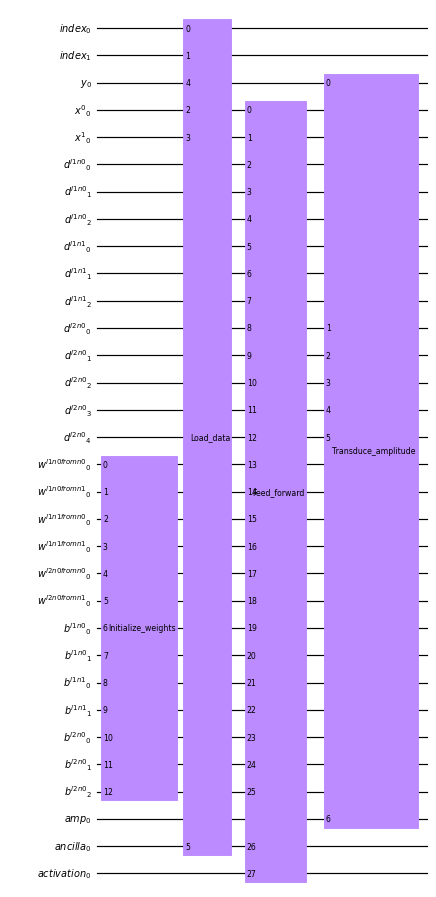

In [4]:
layer_nodes = [2, 2]
input_x = to_binary(np.arange(4), 2)
input_y = np.array([1, 0, 0, 1])
circuit = binary_mlp(layer_nodes, input_x, input_y)

print(circuit.num_qubits, 'qubits')
circuit.draw('mpl', scale=0.6)

## Close-up view of each component

In [5]:
# Setting up the registers
reg_input_index, reg_data_input_y, reg_data, reg_weights, reg_biases, reg_amp = setup_registers(layer_nodes, input_x, input_y, 1)

### Initialize_weights

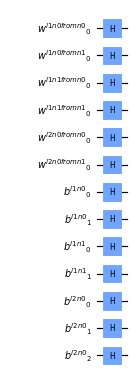

In [9]:
circuit = initialize_weights(reg_weights, reg_biases, gatify=0)
circuit.draw('mpl', scale=0.6)

### Load_data

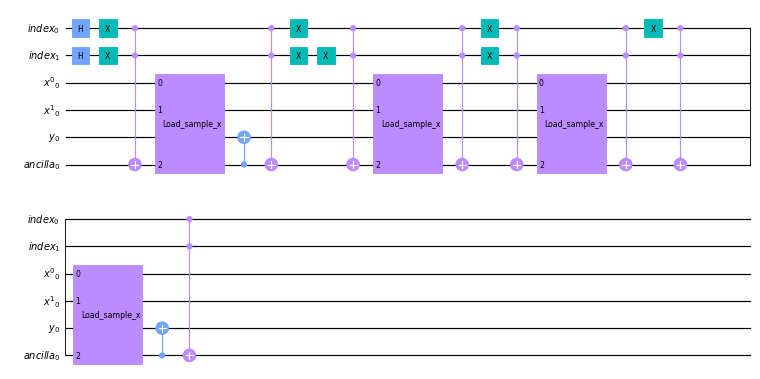

In [11]:
circuit = load_data(reg_input_index, reg_data[0], reg_data_input_y[0], input_x, input_y, 1, gatify=1)
circuit.draw('mpl', scale=0.6)

### Feed_forward

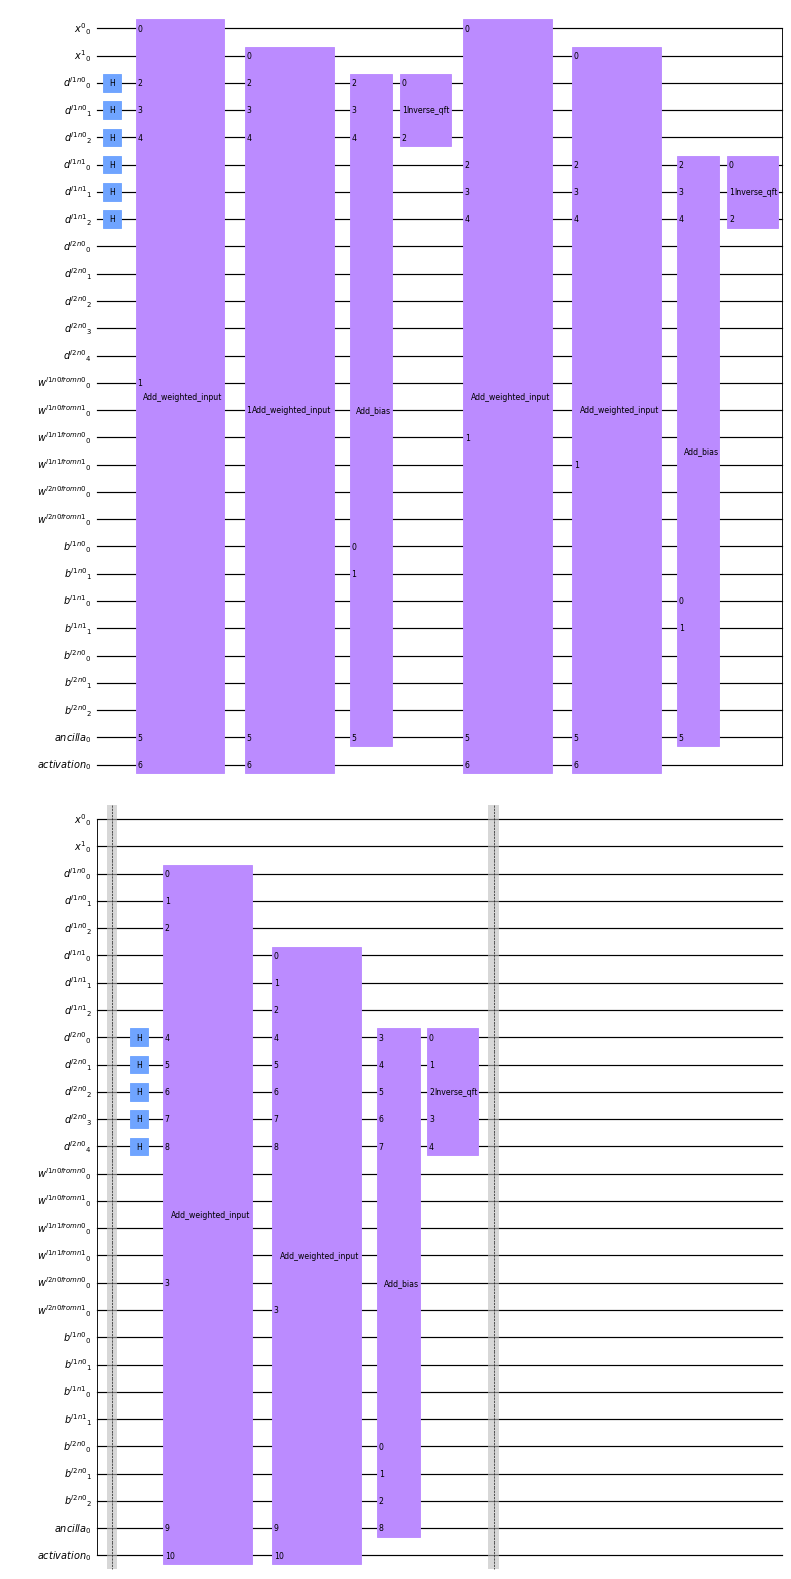

In [15]:
circuit = feedforward(reg_data, reg_weights, reg_biases, gatify=2)
circuit.draw('mpl', scale=0.6)

### Transduce_amplitude

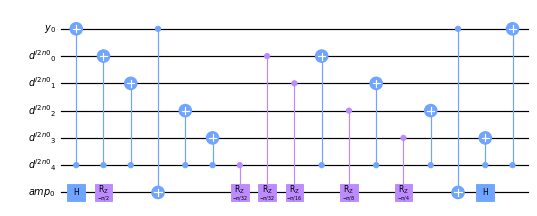

In [17]:
circuit = transduce_amplitude(reg_data_input_y[0], reg_data[-1][0], reg_amp[0], gatify=0)
circuit.draw('mpl', scale=0.6)

## Run the circuit and dump the probability table

In [ ]:
data, probs = get_vector_and_probs(circuit)

svi = StatevectorInspector(data, circuit.qregs)
indices = {'amp': 0}
for reg in circuit.qregs:
    if reg.name.startswith('w') or reg.name.startswith('b'):
        indices[reg.name] = np.newaxis
regs, probs = svi.get_probs(indices=indices, nonzero_only=True)
print(regs)
print_prob_table(probs)
print(max(probs.items(), key=lambda x: x[1]))

In [ ]:
import collections
import pprint

results = collections.defaultdict(list)
results_prob = {}

maxw = None
maxp = 0.
for w in range(64):
    wbin = to_binary(w, 6)
    prob = 0.
    outputs = []
    for x, y in zip(range(4), [1, -1, -1, 1]):
        xbin = to_binary(x, 2)

        l1n0 = max(0, xbin[1] * (1 if wbin[5] == 1 else -1) + xbin[0] * (1 if wbin[4] == 1 else -1))
        l1n1 = max(0, xbin[1] * (1 if wbin[3] == 1 else -1) + xbin[0] * (1 if wbin[2] == 1 else -1))
        l2n0 = l1n0 * (1 if wbin[1] == 1 else -1) + l1n1 * (1 if wbin[0] == 1 else -1)
        l2n0 *= y
        outputs.append(l2n0)

        prob += np.square(np.cos(np.pi / 4. * (1. - l2n0 / 8.)))
    
    outputs = tuple(outputs)
    results[outputs].append(' '.join(str(w) for w in wbin))
    results_prob[outputs] = prob
        
    if prob > maxp:
        maxw = wbin
        maxp = prob
        
print(maxw, maxp)
for outputs in sorted(results):
    print(outputs, ':', results_prob[outputs], results[outputs])